# **Test Pre-trained VGG16**

## **Import Libraries**

In [ ]:
from google.colab import drive
import os
import shutil
import time
from tqdm import tqdm
import glob
import gc

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
import random as rn

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.applications import VGG16

## **Unzip Dataset from Google Drive**

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/CIDL_Group/DATASET.zip -d /content

## **Set Environmental Parameters**

In [ ]:
seed = 42
# The below is necessary for reproducible results of certain Python hash-based operations.
os.environ["PYTHONHASHSEED"]="0"
# The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
np.random.seed(seed)
# The below is necessary for starting core Python generated random numbers in a well-defined state.
rn.seed(seed)
# The below tf.random.set_seed will make random number generation in TensorFlow have a well-defined initial state.
tf.random.set_seed(seed)

In [ ]:
BASE_PATH = '/content/drive/MyDrive/CIDL_Group'

MODELS_PATH = os.path.join(BASE_PATH, 'PRE-TRAINED_MODELS', 'VGG16')
LOCAL_MODELS_PATH = os.path.join(BASE_PATH, 'tmp_models')

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

AUTOTUNE = tf.data.AUTOTUNE
INTERPOLATION = "bilinear"

LOSS_FUNC = 'sparse_categorical_crossentropy'

METRICS = ['accuracy']

In [ ]:
DATASET_PATH = '/content/content/drive/MyDrive/CIDL_Group/DATASET_DEFINITIVO'
TRAIN_PATH = os.path.join(DATASET_PATH, 'train')
VAL_PATH = os.path.join(DATASET_PATH, 'val')
TEST_PATH = os.path.join(DATASET_PATH, 'test')

CLASSES = os.listdir(TRAIN_PATH)

## **Check Class Distribution**

In [ ]:
def get_class_distribution(dataset, to_print=False):
  
  len([name for name in os.listdir(dataset) if os.path.isfile(os.path.join(dataset, name))])

  distribution = []
  total = 0
  for dir in tqdm(os.listdir(dataset)):
    sub_dir = dataset + "/" + dir + "/*"
    number = len(glob.glob(sub_dir))
    distribution.append(number)
    total += number
    
  if print:
    for i in range(len(CLASSES)):
      print(f'Number of {CLASSES[i]}: {distribution[i]}, proportion: {distribution[i]/(total)}')
  
  return distribution, total


def plot_class_distribution(dataset, name):
  distribution, _ = get_class_distribution(dataset, to_print=True)

  plt.figure(figsize=(10, 6), dpi=80)
  plt.bar(CLASSES, height=distribution)
  plt.title(f'Barplot of class distribution of {name} dataset')
  plt.show()

100%|██████████| 4/4 [00:00<00:00, 178.98it/s]

Number of Atelectasis: 1211, proportion: 0.16828793774319067
Number of No Finding: 2430, proportion: 0.3376876042245692
Number of Infiltration: 2430, proportion: 0.3376876042245692
Number of Effusion: 1125, proportion: 0.15633685380767093


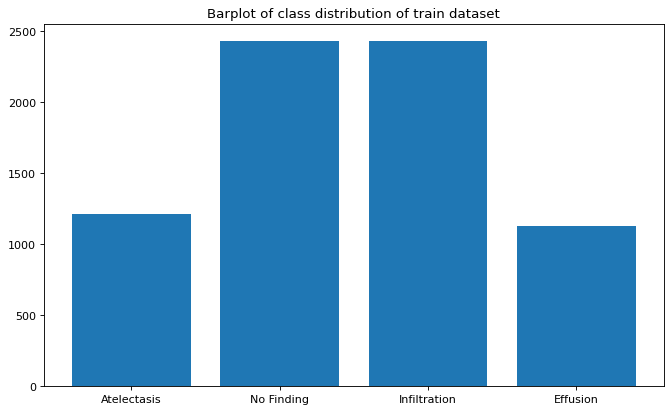

100%|██████████| 4/4 [00:00<00:00, 725.31it/s]

Number of Atelectasis: 135, proportion: 0.16875
Number of No Finding: 270, proportion: 0.3375
Number of Infiltration: 270, proportion: 0.3375
Number of Effusion: 125, proportion: 0.15625


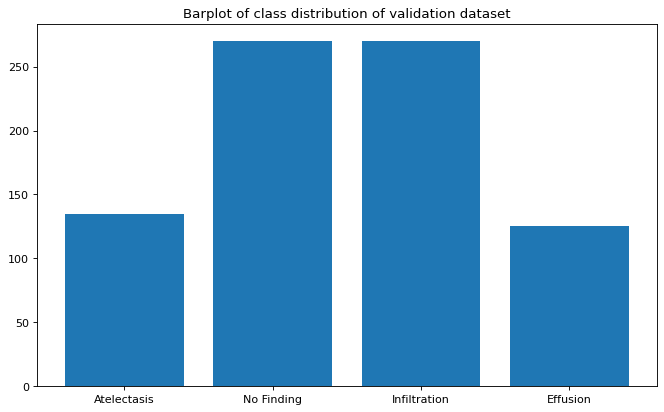

100%|██████████| 4/4 [00:00<00:00, 472.30it/s]


Number of Atelectasis: 150, proportion: 0.1687289088863892
Number of No Finding: 300, proportion: 0.3374578177727784
Number of Infiltration: 300, proportion: 0.3374578177727784
Number of Effusion: 139, proportion: 0.156355455568054


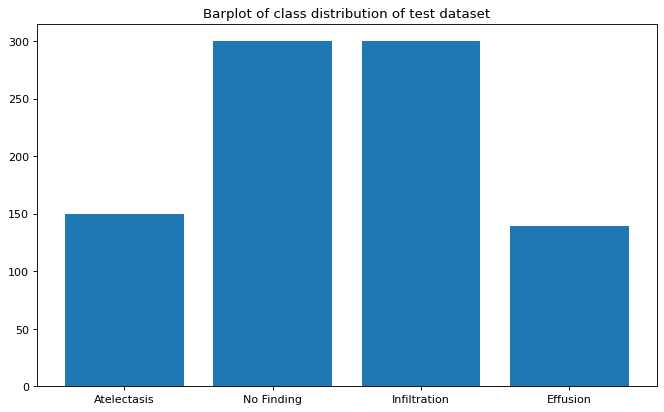

In [ ]:
plot_class_distribution(TRAIN_PATH, 'train')
plot_class_distribution(VAL_PATH, 'validation')
plot_class_distribution(TEST_PATH, 'test')

## **Utility Functions**

In [ ]:
def show_training_and_validation_performance(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b-', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b-', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()


def load_training_set (image_size, batch_size, shuffle=True):
  train_ds = image_dataset_from_directory(
    TRAIN_PATH,
    #label_mode='categorical',
    image_size = image_size,
    batch_size = BATCH_SIZE
  )
  train_ds = train_ds.cache()
  if shuffle:
    train_ds = train_ds.shuffle(BATCH_SIZE * 100)
  train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
  return train_ds


def load_validation_set (image_size, batch_size):
  val_ds = image_dataset_from_directory(
    VAL_PATH,
    #label_mode='categorical',
    image_size = image_size,
    batch_size = BATCH_SIZE
  )
  val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
  return val_ds


def load_test_set (image_size, batch_size):
  test_ds = image_dataset_from_directory(
    TEST_PATH,
    #label_mode='categorical',
    image_size = image_size,
    batch_size = BATCH_SIZE
  )
  test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
  return test_ds


def compile_model (model, optimizer='adam', learning_rate = 0.001):
  if optimizer == 'adam':
    model.compile(loss=LOSS_FUNC,
      optimizer=optimizers.Adam(learning_rate=learning_rate),
      metrics=METRICS)
  elif optimizer == 'rmsprop':
    model.compile(loss=LOSS_FUNC,
                  optimizer = optimizers.RMSprop(learning_rate=learning_rate),
                  metrics=METRICS)
  model.summary()


def run_model (model, model_name, train_set, val_set, epochs = 20, patience=5, min_lr = 1e-8, monitor='val_loss'):
  # local save path for the models
  save_path = os.path.join(LOCAL_MODELS_PATH, f'{model_name}.h5')

  callbacks_list = [
                  keras.callbacks.EarlyStopping(
                      monitor = monitor, 
                      patience = patience),
                  keras.callbacks.ReduceLROnPlateau(
                      monitor = monitor, 
                      factor = 0.8,
                      patience = (patience*6/10), 
                      min_lr = min_lr,
                      min_delta=0.001,
                      verbose = 1),
                  keras.callbacks.ModelCheckpoint(
                      filepath = save_path,
                      monitor = monitor,
                      verbose=1,
                      save_best_only=True)
                  ]
  
  history = model.fit(train_set,
                      epochs = epochs,
                      validation_data = val_set,
                      callbacks = callbacks_list)
  
  # save on Drive only the best model
  best_model_path = os.path.join(MODELS_PATH, f'{model_name}.h5')
  if os.path.exists(best_model_path):
    os.remove(best_model_path)
  shutil.copy(save_path, best_model_path)
  
  return history


def evaluate_model (model, test_set):
  test_loss, test_acc = model.evaluate(test_set)
  print(f'Test accuracy: {test_acc:.3f}\nTest loss: {test_loss:.3f}')

def display_confusion_matrix(model, test_set):
  y_pred = model.predict(test_set)
  y_pred = tf.argmax(y_pred, axis=1)
  y_true = tf.concat([y for x, y in test_set], axis=0)
  print("Classification report: ")
  print(metrics.classification_report(y_true, y_pred, digits = 4))
  metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

## **Load Train, Validation and Test**

In [ ]:
train_set = load_training_set(IMAGE_SIZE, BATCH_SIZE)
train_set_no_shuffle = load_training_set(IMAGE_SIZE, BATCH_SIZE, shuffle=False)
val_set = load_validation_set(IMAGE_SIZE, BATCH_SIZE)
test_set = load_test_set(IMAGE_SIZE, BATCH_SIZE)

NameError: ignored

## **Leverage VGG16 as Feature Extractor**

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=IMAGE_SIZE + (3,)
)
conv_base.summary()
conv_base.trainable = False

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip('horizontal'),
  layers.RandomRotation(0.2)
])

### **Extract features for reuse**

In [ ]:
inputs = keras.Input(shape=IMAGE_SIZE + (3,))
x = keras.applications.vgg16.preprocess_input(inputs)
outputs = conv_base(x)
model = keras.Model(inputs, outputs)

In [ ]:
train_features = model.predict(train_set_no_shuffle)
val_features = model.predict(val_set)
test_features = model.predict(test_set)

FEATURE_SHAPE = train_features.shape[1:]

In [ ]:
del model
K.clear_session()
gc.collect()

202

In [ ]:
# Get labels
def extract_labels(ds):
  ds_labels = []
  for images, labels in ds.unbatch():
    ds_labels.append(labels.numpy())
  return np.array(ds_labels)

In [ ]:
train_labels = extract_labels(train_set_no_shuffle)
val_labels = extract_labels(val_set)
test_labels = extract_labels(test_set)

In [ ]:
# Create Dataset
train_ds = tf.data.Dataset.from_tensor_slices((train_features, train_labels)).batch(BATCH_SIZE).shuffle(BATCH_SIZE * 100)
val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((test_features, test_labels)).batch(BATCH_SIZE)

### **Experiment 1] Dense Layer**

In [ ]:
inputs = keras.Input(shape=FEATURE_SHAPE)
x = layers.Flatten()(inputs)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(len(CLASSES), activation='softmax')(x)
model = keras.Model(inputs, outputs)
compile_model(model, learning_rate=0.001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7, 7, 512)]       0         
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 6,423,812
Trainable params: 6,423,812
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = run_model(model, 'VGG16_exp1', train_set=train_ds, val_set=val_ds, epochs=20, patience=5, monitor='val_loss')

Epoch 1/20
223/225 [============================>.] - ETA: 0s - loss: 5.0137 - accuracy: 0.4620
Epoch 00001: val_loss improved from inf to 1.62338, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/VGG16_exp1.h5
225/225 [==============================] - 7s 26ms/step - loss: 4.9877 - accuracy: 0.4616 - val_loss: 1.6234 - val_accuracy: 0.4412 - lr: 0.0010
Epoch 2/20
223/225 [============================>.] - ETA: 0s - loss: 1.0202 - accuracy: 0.6225
Epoch 00002: val_loss did not improve from 1.62338
225/225 [==============================] - 2s 8ms/step - loss: 1.0195 - accuracy: 0.6223 - val_loss: 1.6719 - val_accuracy: 0.4900 - lr: 0.0010
Epoch 3/20
223/225 [============================>.] - ETA: 0s - loss: 0.6940 - accuracy: 0.7343
Epoch 00003: val_loss improved from 1.62338 to 1.46109, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/VGG16_exp1.h5
225/225 [==============================] - 2s 10ms/step - loss: 0.6943 - accuracy: 0.7340 - val_loss: 1.4611 - val

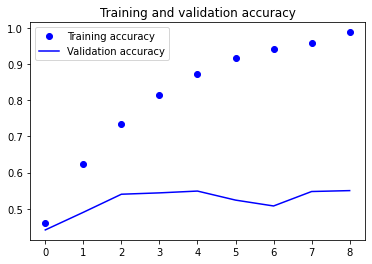

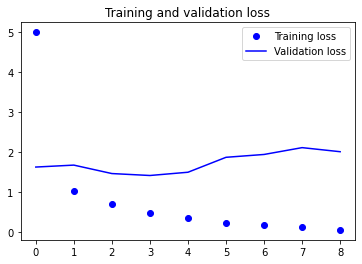

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'VGG16_exp1.h5'))

28/28 [==============================] - 0s 5ms/step - loss: 1.3506 - accuracy: 0.5534
Test accuracy: 0.553
Test loss: 1.351
Classification report: 
              precision    recall  f1-score   support

           0     0.2963    0.1600    0.2078       150
           1     0.5158    0.3525    0.4188       139
           2     0.5187    0.7400    0.6099       300
           3     0.6912    0.6567    0.6735       300

    accuracy                         0.5534       889
   macro avg     0.5055    0.4773    0.4775       889
weighted avg     0.5389    0.5534    0.5336       889



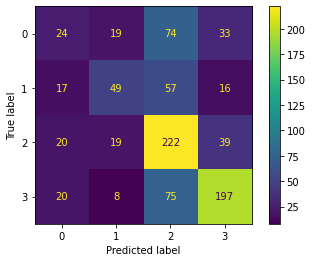

In [ ]:
evaluate_model(model_loaded, test_ds)
display_confusion_matrix(model_loaded, test_ds)

In [ ]:
del model
#del model_loaded
K.clear_session()
gc.collect()

10582

### **Experiment 2] Dense Layer + Dropout**

In [ ]:
inputs = keras.Input(shape=FEATURE_SHAPE)
x = layers.Flatten()(inputs)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(CLASSES), activation='softmax')(x)
model = keras.Model(inputs, outputs)
compile_model(model, learning_rate=0.001)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 7, 7, 512)]       0         
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 256)               6422784   
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 6,423,812
Trainable params: 6,423,812
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = run_model(model, 'VGG16_exp2', train_set=train_ds, val_set=val_ds, epochs=20, patience=5, monitor='val_loss')

Epoch 1/20
225/225 [==============================] - ETA: 0s - loss: 4.5891 - accuracy: 0.3753
Epoch 00001: val_loss improved from inf to 1.27661, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/VGG16_exp2.h5
225/225 [==============================] - 7s 21ms/step - loss: 4.5891 - accuracy: 0.3753 - val_loss: 1.2766 - val_accuracy: 0.4512 - lr: 0.0010
Epoch 2/20
221/225 [============================>.] - ETA: 0s - loss: 1.3112 - accuracy: 0.3920
Epoch 00002: val_loss did not improve from 1.27661
225/225 [==============================] - 3s 11ms/step - loss: 1.3116 - accuracy: 0.3913 - val_loss: 1.3129 - val_accuracy: 0.4075 - lr: 0.0010
Epoch 3/20
221/225 [============================>.] - ETA: 0s - loss: 1.3116 - accuracy: 0.3918
Epoch 00003: val_loss improved from 1.27661 to 1.27007, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/VGG16_exp2.h5
225/225 [==============================] - 3s 12ms/step - loss: 1.3107 - accuracy: 0.3924 - val_loss: 1.2701 - va

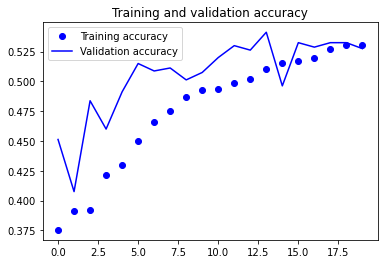

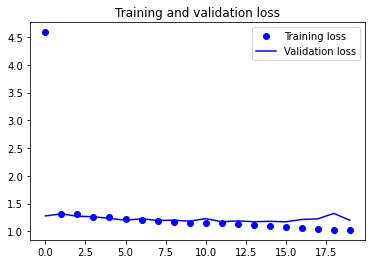

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'VGG16_exp2.h5'))

28/28 [==============================] - 1s 5ms/step - loss: 1.1771 - accuracy: 0.5129
Test accuracy: 0.513
Test loss: 1.177
Classification report: 
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       150
           1     0.0000    0.0000    0.0000       139
           2     0.4205    0.8733    0.5677       300
           3     0.7293    0.6467    0.6855       300

    accuracy                         0.5129       889
   macro avg     0.2875    0.3800    0.3133       889
weighted avg     0.3880    0.5129    0.4229       889



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


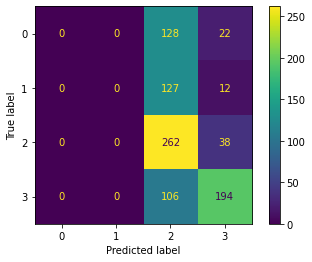

In [ ]:
evaluate_model(model_loaded, test_ds)
display_confusion_matrix(model_loaded, test_ds)

In [ ]:
del model
del model_loaded
K.clear_session()
gc.collect()

15367

### **Experiment 3] 2 Dense + Dropout**

In [ ]:
inputs = keras.Input(shape=FEATURE_SHAPE)
x = layers.Flatten()(inputs)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(CLASSES), activation='softmax')(x)
model = keras.Model(inputs, outputs)
compile_model(model, learning_rate=0.001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7, 7, 512)]       0         
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 4)                 1028  

In [ ]:
history = run_model(model, 'VGG16_exp3', train_set=train_ds, val_set=val_ds, epochs=20, patience=5, monitor='val_loss')

Epoch 1/20
221/225 [============================>.] - ETA: 0s - loss: 3.9527 - accuracy: 0.3410
Epoch 00001: val_loss improved from inf to 1.31185, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/VGG16_exp3.h5
225/225 [==============================] - 5s 20ms/step - loss: 3.9068 - accuracy: 0.3405 - val_loss: 1.3119 - val_accuracy: 0.3775 - lr: 0.0010
Epoch 2/20
223/225 [============================>.] - ETA: 0s - loss: 1.3705 - accuracy: 0.3381
Epoch 00002: val_loss did not improve from 1.31185
225/225 [==============================] - 3s 10ms/step - loss: 1.3713 - accuracy: 0.3378 - val_loss: 1.3315 - val_accuracy: 0.3400 - lr: 0.0010
Epoch 3/20
222/225 [============================>.] - ETA: 0s - loss: 1.3376 - accuracy: 0.3459
Epoch 00003: val_loss did not improve from 1.31185
225/225 [==============================] - 3s 11ms/step - loss: 1.3509 - accuracy: 0.3470 - val_loss: 1.3526 - val_accuracy: 0.3475 - lr: 0.0010
Epoch 4/20
220/225 [============================

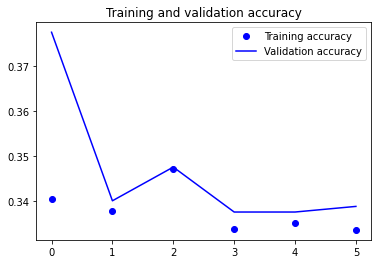

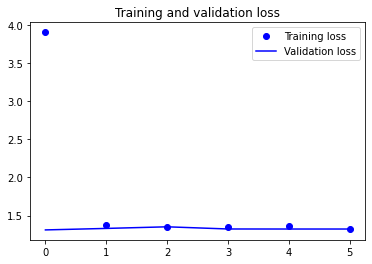

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'VGG16_exp3.h5'))

28/28 [==============================] - 1s 7ms/step - loss: 1.3049 - accuracy: 0.3678
Test accuracy: 0.368
Test loss: 1.305
Classification report: 
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       150
           1     0.0000    0.0000    0.0000       139
           2     0.3492    0.9800    0.5149       300
           3     0.7021    0.1100    0.1902       300

    accuracy                         0.3678       889
   macro avg     0.2628    0.2725    0.1763       889
weighted avg     0.3548    0.3678    0.2379       889



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


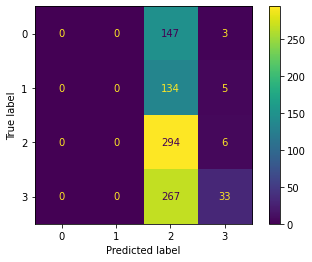

In [ ]:
evaluate_model(model_loaded, test_ds)
display_confusion_matrix(model_loaded, test_ds)

In [ ]:
del model
del model_loaded
K.clear_session()
gc.collect()

7470

### **Experiment 4] Dense + Batch Normalization + Dropout**

In [ ]:
inputs = keras.Input(shape=FEATURE_SHAPE)
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(CLASSES), activation='softmax',)(x)
model = keras.Model(inputs, outputs)
compile_model(model, learning_rate=0.001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7, 7, 512)]       0         
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                             

In [ ]:
history = run_model(model, 'VGG16_exp4', train_set=train_ds, val_set=val_ds, epochs=20, patience=5, monitor='val_loss')

Epoch 1/20
223/225 [============================>.] - ETA: 0s - loss: 1.2886 - accuracy: 0.5185
Epoch 00001: val_loss improved from inf to 1.06221, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/VGG16_exp4.h5
225/225 [==============================] - 7s 28ms/step - loss: 1.2875 - accuracy: 0.5188 - val_loss: 1.0622 - val_accuracy: 0.5875 - lr: 0.0010
Epoch 2/20
221/225 [============================>.] - ETA: 0s - loss: 0.7758 - accuracy: 0.6931
Epoch 00002: val_loss improved from 1.06221 to 1.05224, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/VGG16_exp4.h5
225/225 [==============================] - 3s 11ms/step - loss: 0.7761 - accuracy: 0.6934 - val_loss: 1.0522 - val_accuracy: 0.5863 - lr: 0.0010
Epoch 3/20
221/225 [============================>.] - ETA: 0s - loss: 0.5323 - accuracy: 0.8031
Epoch 00003: val_loss did not improve from 1.05224
225/225 [==============================] - 2s 9ms/step - loss: 0.5340 - accuracy: 0.8023 - val_loss: 1.0760 - val

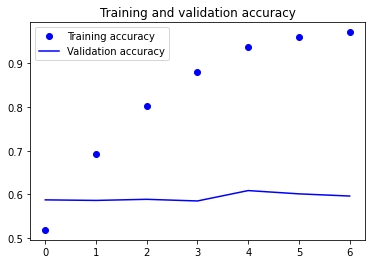

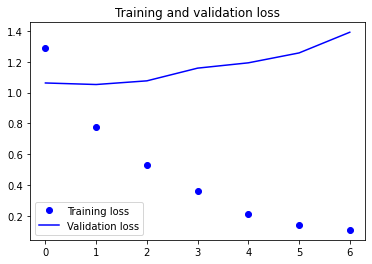

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'VGG16_exp4.h5'))

28/28 [==============================] - 0s 5ms/step - loss: 1.0117 - accuracy: 0.6097
Test accuracy: 0.610
Test loss: 1.012
Classification report: 
              precision    recall  f1-score   support

           0     0.4750    0.1267    0.2000       150
           1     0.5362    0.5324    0.5343       139
           2     0.5607    0.7700    0.6489       300
           3     0.7291    0.7267    0.7279       300

    accuracy                         0.6097       889
   macro avg     0.5753    0.5389    0.5278       889
weighted avg     0.5992    0.6097    0.5819       889



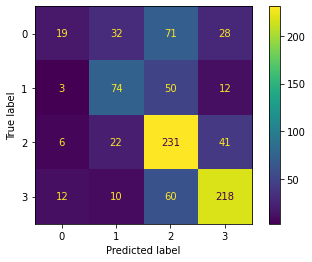

In [ ]:
evaluate_model(model_loaded, test_ds)
display_confusion_matrix(model_loaded, test_ds)

In [ ]:
del model
del model_loaded
K.clear_session()
gc.collect()

10373

### **Experiment 5] Global AVG Pooling + Dense + Batch Normalization + Dropout**

In [ ]:
inputs = keras.Input(shape=FEATURE_SHAPE)
x = layers.GlobalAveragePooling2D()(inputs)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(CLASSES), activation='softmax')(x)
model = keras.Model(inputs, outputs)
compile_model(model, learning_rate=0.001)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 7, 7, 512)]       0         
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 256)               0         
                                                                 
 dropout_1 (Dropout)         (None, 256)               0   

In [ ]:
history = run_model(model, 'VGG16_exp5', train_set=train_ds, val_set=val_ds, epochs=20, patience=5, monitor='val_loss')

Epoch 1/20
223/225 [============================>.] - ETA: 0s - loss: 1.3257 - accuracy: 0.4776
Epoch 00001: val_loss improved from inf to 1.13653, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/VGG16_exp5.h5
225/225 [==============================] - 3s 9ms/step - loss: 1.3223 - accuracy: 0.4790 - val_loss: 1.1365 - val_accuracy: 0.5088 - lr: 0.0010
Epoch 2/20
224/225 [============================>.] - ETA: 0s - loss: 1.0610 - accuracy: 0.5630
Epoch 00002: val_loss improved from 1.13653 to 1.09108, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/VGG16_exp5.h5
225/225 [==============================] - 2s 7ms/step - loss: 1.0615 - accuracy: 0.5630 - val_loss: 1.0911 - val_accuracy: 0.5700 - lr: 0.0010
Epoch 3/20
225/225 [==============================] - ETA: 0s - loss: 0.9853 - accuracy: 0.5970
Epoch 00003: val_loss improved from 1.09108 to 1.02412, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/VGG16_exp5.h5
225/225 [==========================

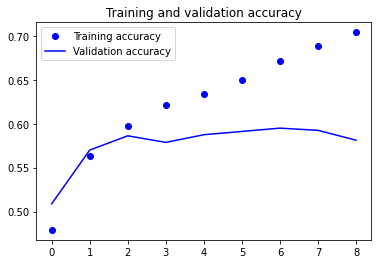

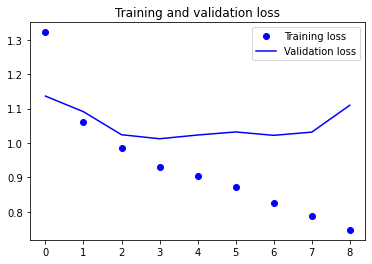

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'VGG16_exp5.h5'))

28/28 [==============================] - 0s 4ms/step - loss: 0.9994 - accuracy: 0.5748
Test accuracy: 0.575
Test loss: 0.999
Classification report: 
              precision    recall  f1-score   support

           0     0.5366    0.1467    0.2304       150
           1     0.5413    0.4245    0.4758       139
           2     0.5228    0.7633    0.6206       300
           3     0.6678    0.6700    0.6689       300

    accuracy                         0.5748       889
   macro avg     0.5671    0.5011    0.4989       889
weighted avg     0.5769    0.5748    0.5484       889



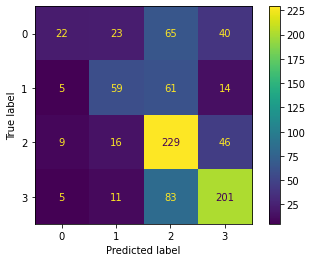

In [ ]:
evaluate_model(model_loaded, test_ds)
display_confusion_matrix(model_loaded, test_ds)

In [ ]:
del model
del model_loaded
K.clear_session()
gc.collect()

13161

### **Experiment 6] Global AVG Pooling + Dense + Dropout**

In [ ]:
inputs = keras.Input(shape=FEATURE_SHAPE)
x = layers.GlobalAveragePooling2D()(inputs)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(CLASSES), activation='softmax')(x)
model = keras.Model(inputs, outputs)
compile_model(model, learning_rate=0.001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7, 7, 512)]       0         
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 132,356
Trainable params: 132,356
Non-trainable params: 0
_______________________________________________________

In [ ]:
history = run_model(model, 'VGG16_exp6', train_set=train_ds, val_set=val_ds, epochs=20, patience=5, monitor='val_loss')

Epoch 1/20
223/225 [============================>.] - ETA: 0s - loss: 1.5219 - accuracy: 0.4351
Epoch 00001: val_loss improved from inf to 1.14292, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/VGG16_exp6.h5
225/225 [==============================] - 4s 15ms/step - loss: 1.5189 - accuracy: 0.4352 - val_loss: 1.1429 - val_accuracy: 0.5025 - lr: 0.0010
Epoch 2/20
222/225 [============================>.] - ETA: 0s - loss: 1.1473 - accuracy: 0.4977
Epoch 00002: val_loss improved from 1.14292 to 1.10209, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/VGG16_exp6.h5
225/225 [==============================] - 1s 5ms/step - loss: 1.1474 - accuracy: 0.4974 - val_loss: 1.1021 - val_accuracy: 0.5125 - lr: 0.0010
Epoch 3/20
222/225 [============================>.] - ETA: 0s - loss: 1.1169 - accuracy: 0.5221
Epoch 00003: val_loss improved from 1.10209 to 1.07928, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/VGG16_exp6.h5
225/225 [=========================

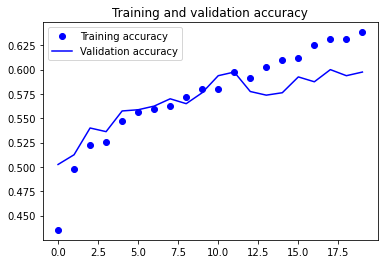

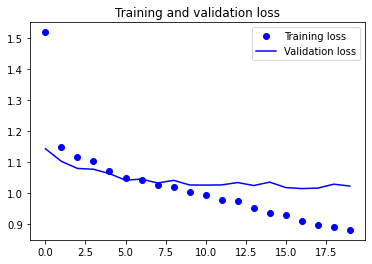

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'VGG16_exp6.h5'))

28/28 [==============================] - 1s 6ms/step - loss: 0.9922 - accuracy: 0.5827
Test accuracy: 0.583
Test loss: 0.992
Classification report: 
              precision    recall  f1-score   support

           0     0.4545    0.2000    0.2778       150
           1     0.5097    0.5683    0.5374       139
           2     0.5628    0.6867    0.6186       300
           3     0.6722    0.6767    0.6744       300

    accuracy                         0.5827       889
   macro avg     0.5498    0.5329    0.5271       889
weighted avg     0.5732    0.5827    0.5672       889



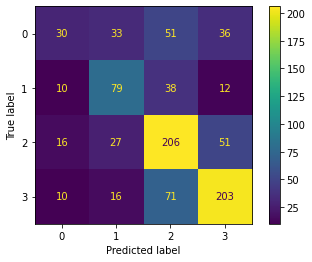

In [ ]:
evaluate_model(model_loaded, test_ds)
display_confusion_matrix(model_loaded, test_ds)

In [ ]:
del model
del model_loaded
K.clear_session()
gc.collect()

4875

### **Experiment 7] Data Augumentation + Global AVG Pooling + Dense + Batch Normalization + Dropout**

In [ ]:
inputs = keras.Input(shape=IMAGE_SIZE + (3,))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(CLASSES), activation='softmax')(x)
model = keras.Model(inputs, outputs)
compile_model(model, learning_rate=0.001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                      

In [ ]:
history = run_model(model, 'VGG16_exp7', train_set=train_set, val_set=val_set, epochs=20, patience=5, monitor='val_loss')

Epoch 1/20
225/225 [==============================] - ETA: 0s - loss: 1.3847 - accuracy: 0.4443
Epoch 00001: val_loss improved from inf to 1.30730, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/VGG16_exp7.h5
225/225 [==============================] - 189s 342ms/step - loss: 1.3847 - accuracy: 0.4443 - val_loss: 1.3073 - val_accuracy: 0.4688 - lr: 0.0010
Epoch 2/20
225/225 [==============================] - ETA: 0s - loss: 1.1707 - accuracy: 0.5125
Epoch 00002: val_loss improved from 1.30730 to 1.09454, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/VGG16_exp7.h5
225/225 [==============================] - 59s 264ms/step - loss: 1.1707 - accuracy: 0.5125 - val_loss: 1.0945 - val_accuracy: 0.5425 - lr: 0.0010
Epoch 3/20
225/225 [==============================] - ETA: 0s - loss: 1.1127 - accuracy: 0.5321
Epoch 00003: val_loss improved from 1.09454 to 1.07153, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/VGG16_exp7.h5
225/225 [===================

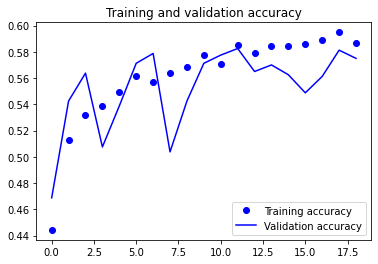

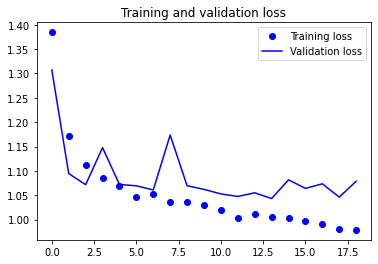

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'VGG16_exp7.h5'))

28/28 [==============================] - 22s 650ms/step - loss: 1.0317 - accuracy: 0.5591
Test accuracy: 0.559
Test loss: 1.032
Classification report: 
              precision    recall  f1-score   support

           0     0.5400    0.1800    0.2700       150
           1     0.4468    0.6043    0.5138       139
           2     0.5473    0.6367    0.5886       300
           3     0.6457    0.6500    0.6478       300

    accuracy                         0.5591       889
   macro avg     0.5449    0.5177    0.5050       889
weighted avg     0.5636    0.5591    0.5431       889



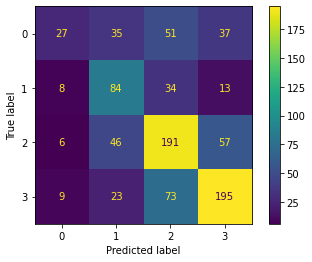

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
K.clear_session()
gc.collect()

10729

### **Experiment 8] Data Augumentation + Global AVG Pooling + Dense + Dropout**

In [ ]:
inputs = keras.Input(shape=IMAGE_SIZE + (3,))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(CLASSES), activation='softmax')(x)
model = keras.Model(inputs, outputs)
compile_model(model, learning_rate=0.001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                      

In [ ]:
history = run_model(model, 'VGG16_exp8', train_set=train_set, val_set=val_set, epochs=50, patience=10, monitor='val_loss')

Epoch 1/50
225/225 [==============================] - ETA: 0s - loss: 1.5205 - accuracy: 0.4332
Epoch 00001: val_loss improved from inf to 1.18185, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/VGG16_exp8.h5
225/225 [==============================] - 60s 263ms/step - loss: 1.5205 - accuracy: 0.4332 - val_loss: 1.1819 - val_accuracy: 0.4812 - lr: 0.0010
Epoch 2/50
225/225 [==============================] - ETA: 0s - loss: 1.1833 - accuracy: 0.4746
Epoch 00002: val_loss improved from 1.18185 to 1.15834, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/VGG16_exp8.h5
225/225 [==============================] - 61s 269ms/step - loss: 1.1833 - accuracy: 0.4746 - val_loss: 1.1583 - val_accuracy: 0.4800 - lr: 0.0010
Epoch 3/50
225/225 [==============================] - ETA: 0s - loss: 1.1581 - accuracy: 0.4982
Epoch 00003: val_loss improved from 1.15834 to 1.13599, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/VGG16_exp8.h5
225/225 [====================

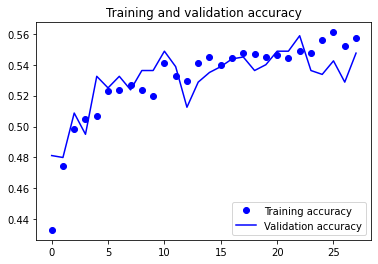

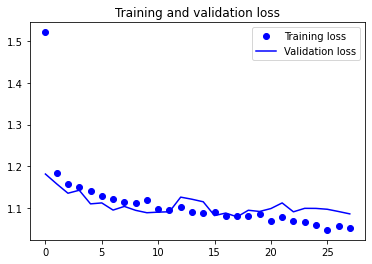

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'VGG16_exp8.h5'))

28/28 [==============================] - 7s 231ms/step - loss: 1.0658 - accuracy: 0.5309
Test accuracy: 0.531
Test loss: 1.066
Classification report: 
              precision    recall  f1-score   support

           0     0.5385    0.0933    0.1591       150
           1     0.4417    0.3813    0.4093       139
           2     0.4849    0.7500    0.5890       300
           3     0.6452    0.6000    0.6218       300

    accuracy                         0.5309       889
   macro avg     0.5276    0.4562    0.4448       889
weighted avg     0.5413    0.5309    0.4994       889



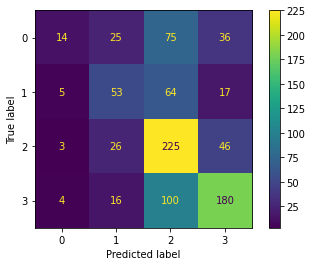

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
K.clear_session()
gc.collect()

16943

### **Experiment 9] Data Augumentation + Global AVG Pooling + Dense + Regularization + Dropout**

In [ ]:
inputs = keras.Input(shape=IMAGE_SIZE + (3,))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu', kernel_regularizer='l2')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(CLASSES), activation='softmax', kernel_regularizer='l2')(x)
model = keras.Model(inputs, outputs)
compile_model(model, learning_rate=0.001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                      

In [ ]:
history = run_model(model, 'VGG16_exp9', train_set=train_set, val_set=val_set, epochs=50, patience=10, monitor='val_loss')

Epoch 1/50
225/225 [==============================] - ETA: 0s - loss: 3.6878 - accuracy: 0.4141
Epoch 00001: val_loss improved from inf to 2.51340, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/VGG16_exp9.h5
225/225 [==============================] - 62s 266ms/step - loss: 3.6878 - accuracy: 0.4141 - val_loss: 2.5134 - val_accuracy: 0.4988 - lr: 0.0010
Epoch 2/50
225/225 [==============================] - ETA: 0s - loss: 2.1561 - accuracy: 0.4755
Epoch 00002: val_loss improved from 2.51340 to 1.83023, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/VGG16_exp9.h5
225/225 [==============================] - 59s 260ms/step - loss: 2.1561 - accuracy: 0.4755 - val_loss: 1.8302 - val_accuracy: 0.5250 - lr: 0.0010
Epoch 3/50
225/225 [==============================] - ETA: 0s - loss: 1.7067 - accuracy: 0.4940
Epoch 00003: val_loss improved from 1.83023 to 1.53855, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/VGG16_exp9.h5
225/225 [====================

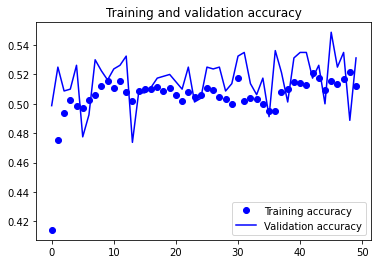

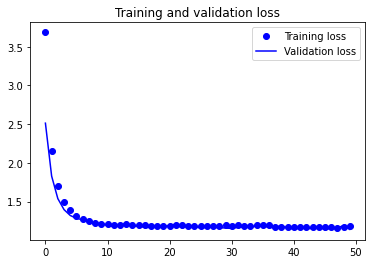

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'VGG16_exp9.h5'))

28/28 [==============================] - 21s 639ms/step - loss: 1.1307 - accuracy: 0.5298
Test accuracy: 0.530
Test loss: 1.131
Classification report: 
              precision    recall  f1-score   support

           0     0.3529    0.0800    0.1304       150
           1     0.4455    0.3525    0.3936       139
           2     0.5000    0.6800    0.5763       300
           3     0.6113    0.6867    0.6468       300

    accuracy                         0.5298       889
   macro avg     0.4774    0.4498    0.4368       889
weighted avg     0.5042    0.5298    0.4963       889



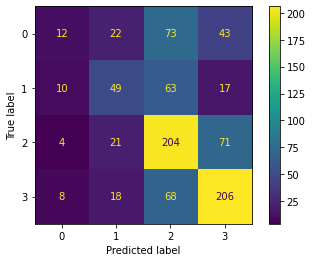

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
K.clear_session()
gc.collect()

16701

## **Fine Tune VGG16**

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
def get_model_to_fine_tune(model, num_of_layers=1, model_name='vgg16', verbose=False):
  if num_of_layers < 1:
      num_of_layers = 1

  res = tf.keras.models.load_model(os.path.join(MODELS_PATH, f'{model}.h5'))
  res.trainable = True

  conv_layers = [layer.name for layer in res.get_layer(model_name).layers if ('conv' in layer.name)]

  layer_names = conv_layers[-num_of_layers:]
  if verbose:
    print(layer_names)

  set_trainable = False
  for layer in res.get_layer(model_name).layers:
    if layer.name in layer_names:
      set_trainable = True
    else:
      set_trainable = False

    if set_trainable:
      layer.trainable = True
    else:
      layer.trainable = False
  
  if verbose:
    for i, layer in enumerate(res.get_layer(model_name).layers):
      print(i, layer.name, layer.trainable)

  return res

In [ ]:
data_aug_model = 'VGG16_exp7'

In [ ]:
data_aug_model_2 = 'VGG16_exp8'

In [ ]:
no_aug_model = 'VGG16_exp6'

### **Fine Tune 1] Unfreeze Last Block + Data Augumentation + Global AVG Pooling + Dense + Batch Normalization + Dropout**

In [ ]:
model = get_model_to_fine_tune(data_aug_model, num_of_layers=3, verbose=True)
compile_model(model, learning_rate=1e-4) # Use a low learning rate to limit the magnitude of the modifications

['block5_conv1', 'block5_conv2', 'block5_conv3']
0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool False
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
             

In [ ]:
history = run_model(model, 'VGG16_fine_tuned_exp1', train_set=train_set, val_set=val_set, epochs=20, patience=7, monitor='val_loss')

Epoch 1/20
225/225 [==============================] - ETA: 0s - loss: 1.1089 - accuracy: 0.5354
Epoch 00001: val_loss improved from inf to 1.22556, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/VGG16_fine_tuned_exp1.h5
225/225 [==============================] - 73s 308ms/step - loss: 1.1089 - accuracy: 0.5354 - val_loss: 1.2256 - val_accuracy: 0.4925 - lr: 1.0000e-04
Epoch 2/20
225/225 [==============================] - ETA: 0s - loss: 1.0264 - accuracy: 0.5741
Epoch 00002: val_loss improved from 1.22556 to 1.11912, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/VGG16_fine_tuned_exp1.h5
225/225 [==============================] - 68s 304ms/step - loss: 1.0264 - accuracy: 0.5741 - val_loss: 1.1191 - val_accuracy: 0.5638 - lr: 1.0000e-04
Epoch 3/20
225/225 [==============================] - ETA: 0s - loss: 0.9803 - accuracy: 0.5998
Epoch 00003: val_loss improved from 1.11912 to 1.10293, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/VGG16_fine_tu

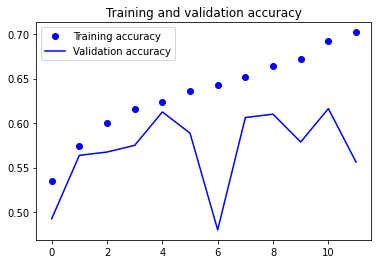

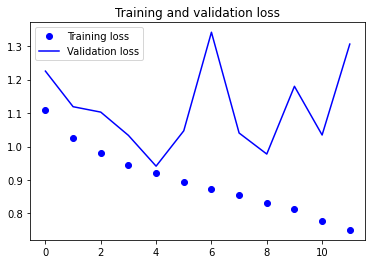

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'VGG16_fine_tuned_exp1.h5'))

28/28 [==============================] - 7s 233ms/step - loss: 0.9438 - accuracy: 0.5917
Test accuracy: 0.592
Test loss: 0.944
Classification report: 
              precision    recall  f1-score   support

           0     0.4462    0.3867    0.4143       150
           1     0.6404    0.4101    0.5000       139
           2     0.5635    0.6800    0.6163       300
           3     0.6721    0.6900    0.6809       300

    accuracy                         0.5917       889
   macro avg     0.5806    0.5417    0.5529       889
weighted avg     0.5924    0.5917    0.5858       889



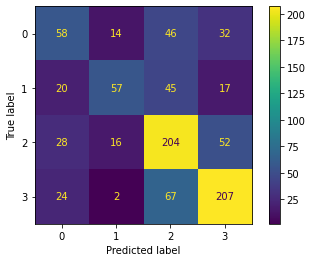

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
gc.collect()
K.clear_session()

### **Fine Tune 2] Unfreeze Last 2 Layers + Data Augumentation + Global AVG Pooling + Dense + Batch Normalization + Dropout**

In [ ]:
model = get_model_to_fine_tune(data_aug_model, num_of_layers=2)
compile_model(model, learning_rate=1e-4) # Use a low learning rate to limit the magnitude of the modifications

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                      

In [ ]:
history = run_model(model, 'VGG16_fine_tuned_exp2', train_set=train_set, val_set=val_set, epochs=20, patience=7, monitor='val_loss')

Epoch 1/20
225/225 [==============================] - ETA: 0s - loss: 1.0587 - accuracy: 0.5543
Epoch 00001: val_loss improved from inf to 1.26382, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/VGG16_fine_tuned_exp2.h5
225/225 [==============================] - 70s 287ms/step - loss: 1.0587 - accuracy: 0.5543 - val_loss: 1.2638 - val_accuracy: 0.4700 - lr: 1.0000e-04
Epoch 2/20
225/225 [==============================] - ETA: 0s - loss: 1.0029 - accuracy: 0.5878
Epoch 00002: val_loss improved from 1.26382 to 1.21994, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/VGG16_fine_tuned_exp2.h5
225/225 [==============================] - 65s 290ms/step - loss: 1.0029 - accuracy: 0.5878 - val_loss: 1.2199 - val_accuracy: 0.4863 - lr: 1.0000e-04
Epoch 3/20
225/225 [==============================] - ETA: 0s - loss: 0.9645 - accuracy: 0.5996
Epoch 00003: val_loss improved from 1.21994 to 1.10924, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/VGG16_fine_tu

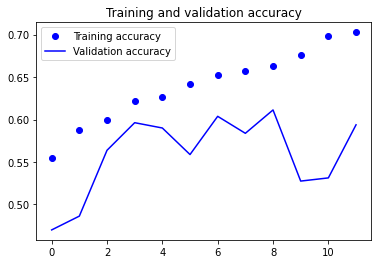

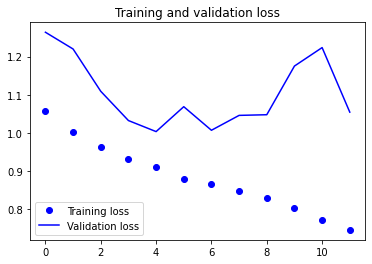

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'VGG16_fine_tuned_exp2.h5'))

28/28 [==============================] - 7s 233ms/step - loss: 0.9837 - accuracy: 0.5782
Test accuracy: 0.578
Test loss: 0.984
Classification report: 
              precision    recall  f1-score   support

           0     0.4492    0.3533    0.3955       150
           1     0.6866    0.3309    0.4466       139
           2     0.5197    0.7900    0.6270       300
           3     0.7177    0.5933    0.6496       300

    accuracy                         0.5782       889
   macro avg     0.5933    0.5169    0.5297       889
weighted avg     0.6007    0.5782    0.5674       889



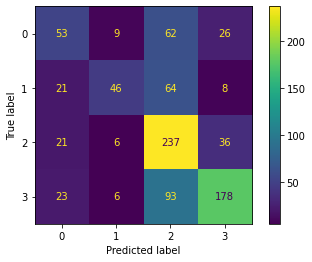

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
gc.collect()
K.clear_session()

### **Fine Tune 3] Unfreeze Last Block + Data Augumentation + Global AVG Pooling + Dense + Dropout**

In [ ]:
model = get_model_to_fine_tune(data_aug_model_2, num_of_layers=3)
compile_model(model, learning_rate=1e-4) # Use a low learning rate to limit the magnitude of the modifications

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                      

In [ ]:
history = run_model(model, 'VGG16_fine_tuned_exp3', train_set=train_set, val_set=val_set, epochs=20, patience=7, monitor='val_loss')

Epoch 1/20
225/225 [==============================] - ETA: 0s - loss: 1.1789 - accuracy: 0.4915
Epoch 00001: val_loss improved from inf to 1.08723, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/VGG16_fine_tuned_exp3.h5
225/225 [==============================] - 73s 309ms/step - loss: 1.1789 - accuracy: 0.4915 - val_loss: 1.0872 - val_accuracy: 0.5450 - lr: 1.0000e-04
Epoch 2/20
225/225 [==============================] - ETA: 0s - loss: 1.0963 - accuracy: 0.5477
Epoch 00002: val_loss improved from 1.08723 to 1.07278, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/VGG16_fine_tuned_exp3.h5
225/225 [==============================] - 68s 301ms/step - loss: 1.0963 - accuracy: 0.5477 - val_loss: 1.0728 - val_accuracy: 0.5537 - lr: 1.0000e-04
Epoch 3/20
225/225 [==============================] - ETA: 0s - loss: 1.0551 - accuracy: 0.5624
Epoch 00003: val_loss improved from 1.07278 to 1.03818, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/VGG16_fine_tu

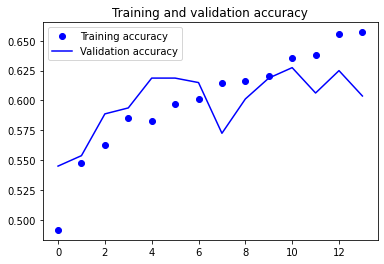

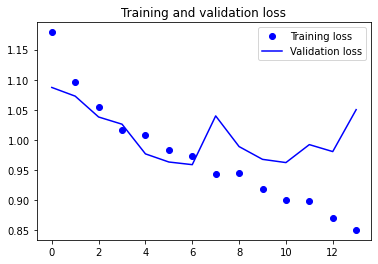

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'VGG16_fine_tuned_exp3.h5'))

28/28 [==============================] - 7s 232ms/step - loss: 0.9740 - accuracy: 0.5782
Test accuracy: 0.578
Test loss: 0.974
Classification report: 
              precision    recall  f1-score   support

           0     0.4031    0.3467    0.3728       150
           1     0.5946    0.4748    0.5280       139
           2     0.5469    0.6800    0.6062       300
           3     0.6957    0.6400    0.6667       300

    accuracy                         0.5782       889
   macro avg     0.5601    0.5354    0.5434       889
weighted avg     0.5803    0.5782    0.5750       889



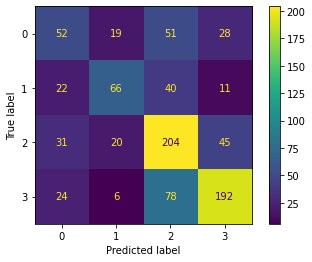

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
gc.collect()
K.clear_session()

### **Fine Tune 4] Unfreeze Last 2 Layers + Data Augumentation + Global AVG Pooling + Dense + Dropout**

In [ ]:
model = get_model_to_fine_tune(data_aug_model_2, num_of_layers=2)
compile_model(model, learning_rate=1e-4) # Use a low learning rate to limit the magnitude of the modifications

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                      

In [ ]:
history = run_model(model, 'VGG16_fine_tuned_exp4', train_set=train_set, val_set=val_set, epochs=20, patience=7, monitor='val_loss')

Epoch 1/20
225/225 [==============================] - ETA: 0s - loss: 1.1530 - accuracy: 0.5031
Epoch 00001: val_loss improved from inf to 1.09990, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/VGG16_fine_tuned_exp4.h5
225/225 [==============================] - 66s 282ms/step - loss: 1.1530 - accuracy: 0.5031 - val_loss: 1.0999 - val_accuracy: 0.5263 - lr: 1.0000e-04
Epoch 2/20
225/225 [==============================] - ETA: 0s - loss: 1.0780 - accuracy: 0.5491
Epoch 00002: val_loss improved from 1.09990 to 1.09766, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/VGG16_fine_tuned_exp4.h5
225/225 [==============================] - 65s 287ms/step - loss: 1.0780 - accuracy: 0.5491 - val_loss: 1.0977 - val_accuracy: 0.5437 - lr: 1.0000e-04
Epoch 3/20
225/225 [==============================] - ETA: 0s - loss: 1.0472 - accuracy: 0.5609
Epoch 00003: val_loss improved from 1.09766 to 1.02887, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/VGG16_fine_tu

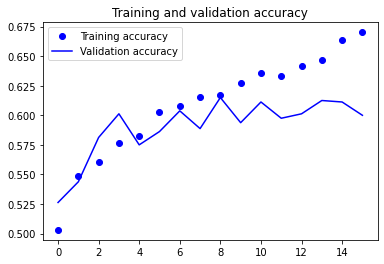

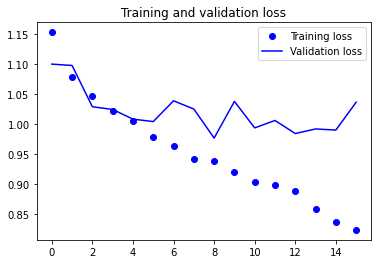

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'VGG16_fine_tuned_exp4.h5'))

28/28 [==============================] - 7s 230ms/step - loss: 0.9597 - accuracy: 0.5894
Test accuracy: 0.589
Test loss: 0.960
Classification report: 
              precision    recall  f1-score   support

           0     0.4298    0.3267    0.3712       150
           1     0.5286    0.5324    0.5305       139
           2     0.5757    0.7100    0.6358       300
           3     0.7094    0.6267    0.6655       300

    accuracy                         0.5894       889
   macro avg     0.5609    0.5489    0.5507       889
weighted avg     0.5888    0.5894    0.5847       889



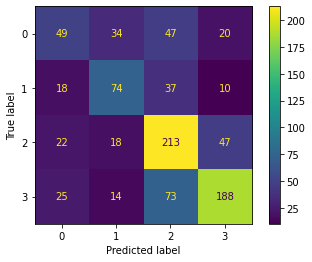

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
gc.collect()
K.clear_session()

### **Fine Tune 5] Unfreeze Last 4 Layers + Data Augumentation + Global AVG Pooling + Dense + Dropout**

In [ ]:
model = get_model_to_fine_tune(data_aug_model_2, num_of_layers=4)
compile_model(model, learning_rate=1e-4) # Use a low learning rate to limit the magnitude of the modifications

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                      

In [ ]:
history = run_model(model, 'VGG16_fine_tuned_exp5', train_set=train_set, val_set=val_set, epochs=20, patience=7, monitor='val_loss')

Epoch 1/20
225/225 [==============================] - ETA: 0s - loss: 1.2916 - accuracy: 0.4421
Epoch 00001: val_loss improved from inf to 1.20002, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/VGG16_fine_tuned_exp5.h5
225/225 [==============================] - 74s 328ms/step - loss: 1.2916 - accuracy: 0.4421 - val_loss: 1.2000 - val_accuracy: 0.5063 - lr: 1.0000e-04
Epoch 2/20
225/225 [==============================] - ETA: 0s - loss: 1.1826 - accuracy: 0.5001
Epoch 00002: val_loss improved from 1.20002 to 1.18645, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/VGG16_fine_tuned_exp5.h5
225/225 [==============================] - 72s 318ms/step - loss: 1.1826 - accuracy: 0.5001 - val_loss: 1.1864 - val_accuracy: 0.4800 - lr: 1.0000e-04
Epoch 3/20
225/225 [==============================] - ETA: 0s - loss: 1.1305 - accuracy: 0.5268
Epoch 00003: val_loss improved from 1.18645 to 1.15243, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/VGG16_fine_tu

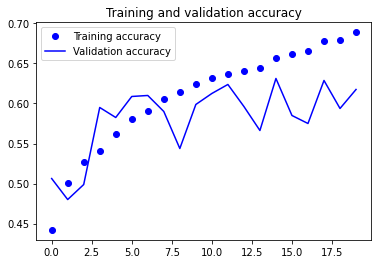

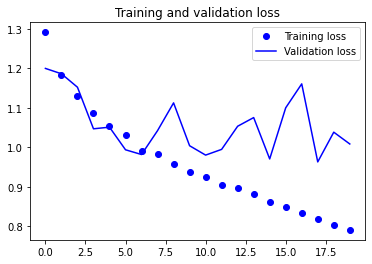

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'VGG16_fine_tuned_exp5.h5'))

28/28 [==============================] - 7s 229ms/step - loss: 0.9540 - accuracy: 0.6052
Test accuracy: 0.605
Test loss: 0.954
Classification report: 
              precision    recall  f1-score   support

           0     0.4561    0.3467    0.3939       150
           1     0.5833    0.5540    0.5683       139
           2     0.5744    0.7333    0.6442       300
           3     0.7269    0.6300    0.6750       300

    accuracy                         0.6052       889
   macro avg     0.5852    0.5660    0.5704       889
weighted avg     0.6073    0.6052    0.6005       889



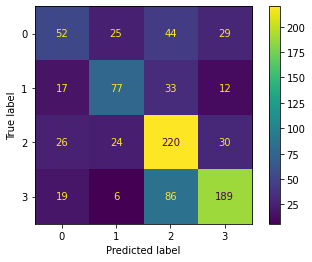

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
gc.collect()
K.clear_session()

### **Fine Tune 6] Unfreeze Last 4 Layers + Data Augumentation + Global AVG Pooling + Dense + Batch Normalization + Dropout**

In [ ]:
model = get_model_to_fine_tune(data_aug_model, num_of_layers=4)
compile_model(model, learning_rate=1e-4) # Use a low learning rate to limit the magnitude of the modifications

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                      

In [ ]:
history = run_model(model, 'VGG16_fine_tuned_exp6', train_set=train_set, val_set=val_set, epochs=20, patience=7, monitor='val_loss')

Epoch 1/20
225/225 [==============================] - ETA: 0s - loss: 1.1331 - accuracy: 0.5265
Epoch 00001: val_loss improved from inf to 1.42585, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/VGG16_fine_tuned_exp6.h5
225/225 [==============================] - 78s 329ms/step - loss: 1.1331 - accuracy: 0.5265 - val_loss: 1.4258 - val_accuracy: 0.4250 - lr: 1.0000e-04
Epoch 2/20
225/225 [==============================] - ETA: 0s - loss: 1.0352 - accuracy: 0.5748
Epoch 00002: val_loss improved from 1.42585 to 1.04595, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/VGG16_fine_tuned_exp6.h5
225/225 [==============================] - 73s 326ms/step - loss: 1.0352 - accuracy: 0.5748 - val_loss: 1.0459 - val_accuracy: 0.5638 - lr: 1.0000e-04
Epoch 3/20
225/225 [==============================] - ETA: 0s - loss: 0.9829 - accuracy: 0.5998
Epoch 00003: val_loss improved from 1.04595 to 1.03021, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/VGG16_fine_tu

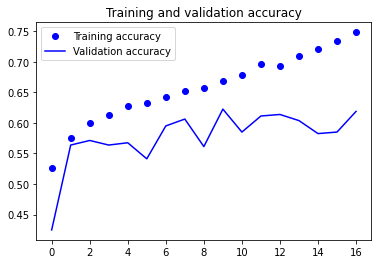

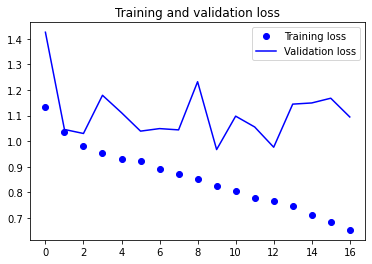

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'VGG16_fine_tuned_exp6.h5'))

28/28 [==============================] - 7s 232ms/step - loss: 0.9727 - accuracy: 0.6085
Test accuracy: 0.609
Test loss: 0.973
Classification report: 
              precision    recall  f1-score   support

           0     0.5104    0.3267    0.3984       150
           1     0.6636    0.5108    0.5772       139
           2     0.5461    0.8100    0.6523       300
           3     0.7386    0.5933    0.6580       300

    accuracy                         0.6085       889
   macro avg     0.6147    0.5602    0.5715       889
weighted avg     0.6234    0.6085    0.5997       889



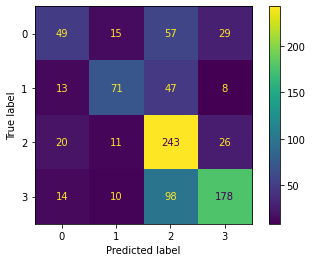

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
gc.collect()
K.clear_session()

### **Fine Tune 7] Unfreeze Last Block + Data Augumentation + Global AVG Pooling + Dense + Dropout + RMSProp**

In [ ]:
model = get_model_to_fine_tune(data_aug_model, num_of_layers=3)
compile_model(model, learning_rate=1e-4, optimizer='rmsprop') # Use a low learning rate to limit the magnitude of the modifications

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                      

In [ ]:
history = run_model(model, 'VGG16_fine_tuned_exp7', train_set=train_set, val_set=val_set, epochs=20, patience=7, monitor='val_loss')

Epoch 1/20
225/225 [==============================] - ETA: 0s - loss: 1.2687 - accuracy: 0.4767
Epoch 00001: val_loss improved from inf to 1.08700, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/VGG16_fine_tuned_exp9.h5
225/225 [==============================] - 76s 322ms/step - loss: 1.2687 - accuracy: 0.4767 - val_loss: 1.0870 - val_accuracy: 0.5387 - lr: 1.0000e-04
Epoch 2/20
225/225 [==============================] - ETA: 0s - loss: 1.1269 - accuracy: 0.5347
Epoch 00002: val_loss improved from 1.08700 to 1.03823, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/VGG16_fine_tuned_exp9.h5
225/225 [==============================] - 71s 317ms/step - loss: 1.1269 - accuracy: 0.5347 - val_loss: 1.0382 - val_accuracy: 0.5950 - lr: 1.0000e-04
Epoch 3/20
225/225 [==============================] - ETA: 0s - loss: 1.0817 - accuracy: 0.5610
Epoch 00003: val_loss improved from 1.03823 to 1.02538, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/VGG16_fine_tu

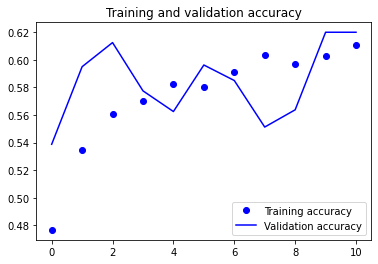

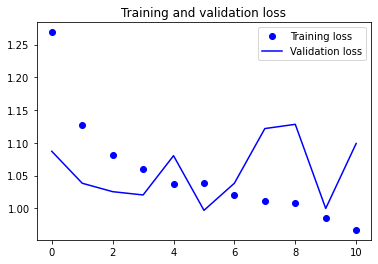

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'VGG16_fine_tuned_exp7.h5'))

28/28 [==============================] - 7s 238ms/step - loss: 1.0097 - accuracy: 0.5804
Test accuracy: 0.580
Test loss: 1.010
Classification report: 
              precision    recall  f1-score   support

           0     0.4545    0.2667    0.3361       150
           1     0.5608    0.5971    0.5784       139
           2     0.5706    0.6467    0.6062       300
           3     0.6358    0.6633    0.6493       300

    accuracy                         0.5804       889
   macro avg     0.5554    0.5434    0.5425       889
weighted avg     0.5715    0.5804    0.5708       889



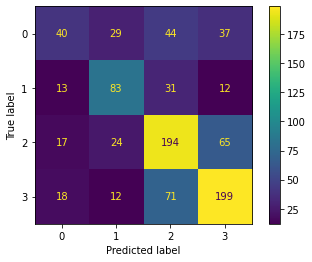

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
gc.collect()
K.clear_session()

# **New Dataset**

In [ ]:
!unzip /content/drive/MyDrive/CIDL_Group/ULTIMO_DATASET_VALE.zip -d /content

Streaming output truncated to the last 5000 lines.
  inflating: /content/content/drive/MyDrive/CIDL_Group/ ULTIMO_DATASET/train/Infiltration/00007336_000.png  
  inflating: /content/content/drive/MyDrive/CIDL_Group/ ULTIMO_DATASET/train/Infiltration/00021327_000.png  
  inflating: /content/content/drive/MyDrive/CIDL_Group/ ULTIMO_DATASET/train/Infiltration/00022325_001.png  
  inflating: /content/content/drive/MyDrive/CIDL_Group/ ULTIMO_DATASET/train/Infiltration/00008899_009.png  
  inflating: /content/content/drive/MyDrive/CIDL_Group/ ULTIMO_DATASET/train/Infiltration/00028039_000.png  
  inflating: /content/content/drive/MyDrive/CIDL_Group/ ULTIMO_DATASET/train/Infiltration/00030460_000.png  
  inflating: /content/content/drive/MyDrive/CIDL_Group/ ULTIMO_DATASET/train/Infiltration/00022572_023.png  
  inflating: /content/content/drive/MyDrive/CIDL_Group/ ULTIMO_DATASET/train/Infiltration/00021145_000.png  
  inflating: /content/content/drive/MyDrive/CIDL_Group/ ULTIMO_DATASET/train/

In [ ]:
UPDATED_DATASET = '/content/content/drive/MyDrive/CIDL_Group/ ULTIMO_DATASET'
TRAIN_PATH = os.path.join(UPDATED_DATASET, 'train')
VAL_PATH = os.path.join(UPDATED_DATASET, 'val')
TEST_PATH = os.path.join(UPDATED_DATASET, 'test')

CLASSES = os.listdir(TRAIN_PATH)

100%|██████████| 4/4 [00:00<00:00, 26.47it/s]


Number of No Finding: 3240, proportion: 0.2907655030063717
Number of Atelectasis: 2384, proportion: 0.2139459750516019
Number of Effusion: 2279, proportion: 0.20452301893565467
Number of Infiltration: 3240, proportion: 0.2907655030063717


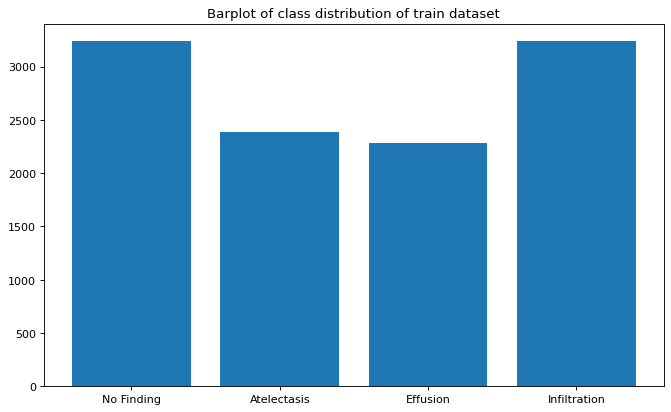

100%|██████████| 4/4 [00:00<00:00, 249.55it/s]


Number of No Finding: 360, proportion: 0.2786377708978328
Number of Atelectasis: 289, proportion: 0.2236842105263158
Number of Effusion: 283, proportion: 0.21904024767801858
Number of Infiltration: 360, proportion: 0.2786377708978328


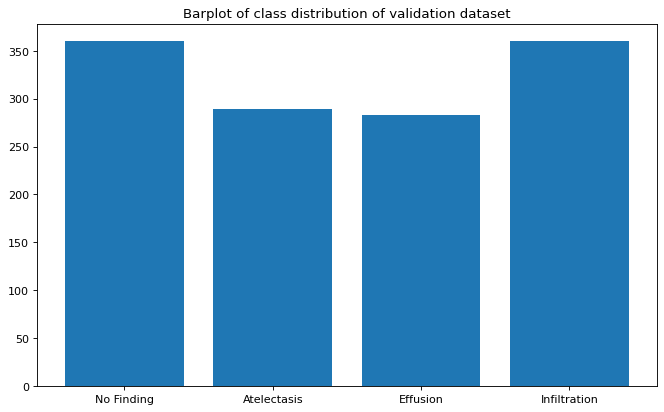

100%|██████████| 4/4 [00:00<00:00, 112.94it/s]


Number of No Finding: 400, proportion: 0.27816411682892905
Number of Atelectasis: 324, proportion: 0.22531293463143254
Number of Effusion: 314, proportion: 0.21835883171070933
Number of Infiltration: 400, proportion: 0.27816411682892905


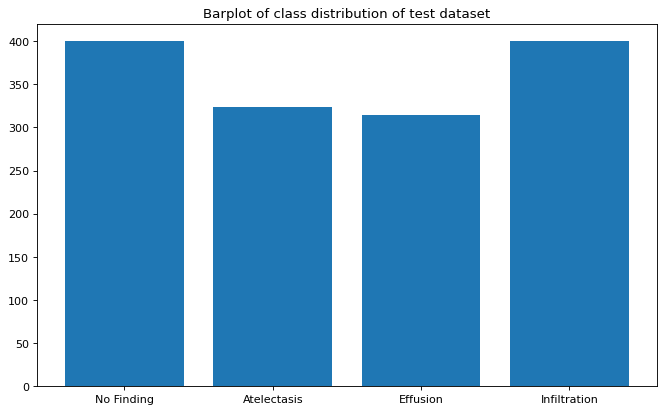

In [ ]:
plot_class_distribution(TRAIN_PATH, 'train')
plot_class_distribution(VAL_PATH, 'validation')
plot_class_distribution(TEST_PATH, 'test')

In [ ]:
train_set = load_training_set(IMAGE_SIZE, BATCH_SIZE)
val_set = load_validation_set(IMAGE_SIZE, BATCH_SIZE)
test_set = load_test_set(IMAGE_SIZE, BATCH_SIZE)

Found 11143 files belonging to 4 classes.
Found 11143 files belonging to 4 classes.
Found 1292 files belonging to 4 classes.
Found 1438 files belonging to 4 classes.


## **Experiment 1] Global AVG Pooling + Dense + Dropout**

In [ ]:
inputs = keras.Input(shape=IMAGE_SIZE + (3,))
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(CLASSES), activation='softmax')(x)
model = keras.Model(inputs, outputs)
compile_model(model, learning_rate=0.001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               131328

In [ ]:
history = run_model(model, 'VGG16_updated_dataset_exp1', train_set=train_set, val_set=val_set, epochs=20, patience=7, monitor='val_loss')

Epoch 1/20
349/349 [==============================] - ETA: 0s - loss: 1.4297 - accuracy: 0.4221
Epoch 00001: val_loss improved from inf to 1.15119, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/VGG16_updated_dataset_exp1.h5
349/349 [==============================] - 264s 305ms/step - loss: 1.4297 - accuracy: 0.4221 - val_loss: 1.1512 - val_accuracy: 0.5023 - lr: 0.0010
Epoch 2/20
349/349 [==============================] - ETA: 0s - loss: 1.1783 - accuracy: 0.4868
Epoch 00002: val_loss improved from 1.15119 to 1.09467, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/VGG16_updated_dataset_exp1.h5
349/349 [==============================] - 90s 259ms/step - loss: 1.1783 - accuracy: 0.4868 - val_loss: 1.0947 - val_accuracy: 0.5426 - lr: 0.0010
Epoch 3/20
349/349 [==============================] - ETA: 0s - loss: 1.1403 - accuracy: 0.5087
Epoch 00003: val_loss did not improve from 1.09467
349/349 [==============================] - 89s 255ms/step - loss: 1.1403 - a

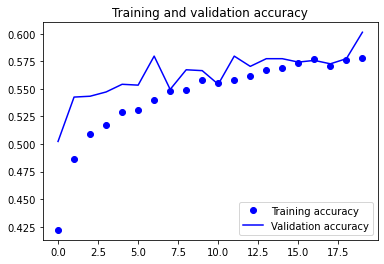

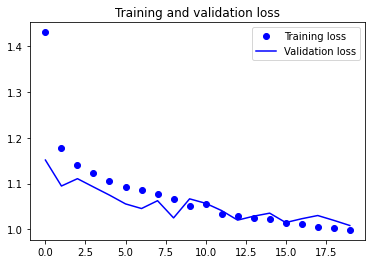

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'VGG16_updated_dataset_exp1.h5'))

45/45 [==============================] - 11s 227ms/step - loss: 1.0299 - accuracy: 0.5786
Test accuracy: 0.579
Test loss: 1.030
Classification report: 
              precision    recall  f1-score   support

           0     0.5336    0.3920    0.4520       324
           1     0.5782    0.5414    0.5592       314
           2     0.5300    0.6850    0.5976       400
           3     0.6710    0.6525    0.6616       400

    accuracy                         0.5786      1438
   macro avg     0.5782    0.5677    0.5676      1438
weighted avg     0.5805    0.5786    0.5742      1438



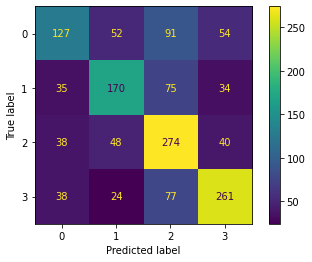

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
gc.collect()
K.clear_session()

## **Experiment 1 Fine Tune Last Block] Global AVG Pooling + Dense + Dropout**

In [ ]:
updated_dataset_no_aug_model = 'VGG16_updated_dataset_exp1'

In [ ]:
model = get_model_to_fine_tune(updated_dataset_no_aug_model, num_of_layers=3)
compile_model(model, learning_rate=1e-4) # Use a low learning rate to limit the magnitude of the modifications

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               131328

In [ ]:
history = run_model(model, 'VGG16_updated_dataset_ft_exp1', train_set=train_set, val_set=val_set, epochs=20, patience=7, monitor='val_loss')

Epoch 1/20
349/349 [==============================] - ETA: 0s - loss: 1.1581 - accuracy: 0.5080
Epoch 00001: val_loss improved from inf to 1.05046, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/VGG16_updated_dataset_ft_exp1.h5
349/349 [==============================] - 104s 288ms/step - loss: 1.1581 - accuracy: 0.5080 - val_loss: 1.0505 - val_accuracy: 0.5588 - lr: 1.0000e-04
Epoch 2/20
349/349 [==============================] - ETA: 0s - loss: 0.9922 - accuracy: 0.6049
Epoch 00002: val_loss improved from 1.05046 to 0.98500, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/VGG16_updated_dataset_ft_exp1.h5
349/349 [==============================] - 101s 289ms/step - loss: 0.9922 - accuracy: 0.6049 - val_loss: 0.9850 - val_accuracy: 0.6122 - lr: 1.0000e-04
Epoch 3/20
349/349 [==============================] - ETA: 0s - loss: 0.9127 - accuracy: 0.6344
Epoch 00003: val_loss improved from 0.98500 to 0.97309, saving model to /content/drive/MyDrive/CIDL_Group/tmp_mo

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'VGG16_updated_dataset_ft_exp1.h5'))

45/45 [==============================] - 11s 228ms/step - loss: 0.9135 - accuracy: 0.6662
Test accuracy: 0.666
Test loss: 0.914
Classification report: 
              precision    recall  f1-score   support

           0     0.5888    0.6142    0.6012       324
           1     0.6536    0.7452    0.6964       314
           2     0.6488    0.6650    0.6568       400
           3     0.7801    0.6475    0.7077       400

    accuracy                         0.6662      1438
   macro avg     0.6678    0.6680    0.6655      1438
weighted avg     0.6728    0.6662    0.6671      1438



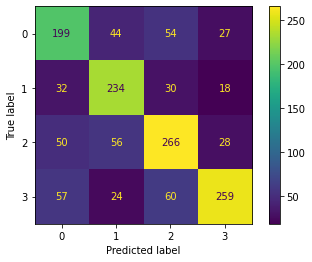

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
gc.collect()
K.clear_session()

## **Experiment 1 Fine Tune Last 3 Blocks] Global AVG Pooling + Dense + Dropout**

In [ ]:
model = get_model_to_fine_tune(updated_dataset_no_aug_model, num_of_layers=9)
compile_model(model, learning_rate=1e-5) # Use a low learning rate to limit the magnitude of the modifications

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               131328

In [ ]:
history = run_model(model, 'VGG16_updated_dataset_ft2_exp1', train_set=train_set, val_set=val_set, epochs=50, patience=7, monitor='val_loss')

Epoch 1/50
349/349 [==============================] - ETA: 0s - loss: 1.0056 - accuracy: 0.5796
Epoch 00001: val_loss improved from inf to 0.98687, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/tmp.h5
349/349 [==============================] - 281s 359ms/step - loss: 1.0056 - accuracy: 0.5796 - val_loss: 0.9869 - val_accuracy: 0.6068 - lr: 1.0000e-05
Epoch 2/50
349/349 [==============================] - ETA: 0s - loss: 0.9012 - accuracy: 0.6282
Epoch 00002: val_loss improved from 0.98687 to 0.95884, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/tmp.h5
349/349 [==============================] - 105s 299ms/step - loss: 0.9012 - accuracy: 0.6282 - val_loss: 0.9588 - val_accuracy: 0.6138 - lr: 1.0000e-05
Epoch 3/50
349/349 [==============================] - ETA: 0s - loss: 0.8335 - accuracy: 0.6559
Epoch 00003: val_loss improved from 0.95884 to 0.93199, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/tmp.h5
349/349 [==============================]

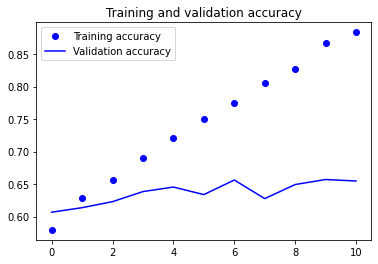

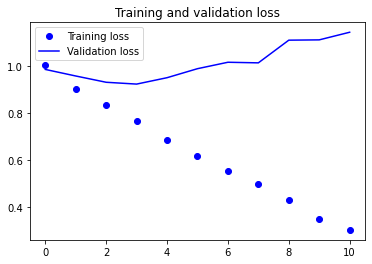

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'VGG16_updated_dataset_ft2_exp1.h5'))

45/45 [==============================] - 28s 525ms/step - loss: 0.9334 - accuracy: 0.6321
Test accuracy: 0.632
Test loss: 0.933
Classification report: 
              precision    recall  f1-score   support

           0     0.5394    0.5494    0.5443       324
           1     0.6228    0.6783    0.6494       314
           2     0.6580    0.5675    0.6094       400
           3     0.6912    0.7275    0.7089       400

    accuracy                         0.6321      1438
   macro avg     0.6278    0.6307    0.6280      1438
weighted avg     0.6328    0.6321    0.6311      1438



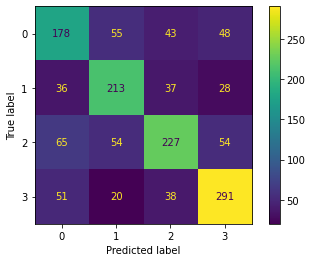

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
gc.collect()
K.clear_session()

## **Experiment 2] Data Augumentation + Global AVG Pooling + Dense + Dropout**

In [ ]:
inputs = keras.Input(shape=IMAGE_SIZE + (3,))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(CLASSES), activation='softmax')(x)
model = keras.Model(inputs, outputs)
compile_model(model, learning_rate=0.001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                      

In [ ]:
history = run_model(model, 'VGG16_updated_dataset_exp2', train_set=train_set, val_set=val_set, epochs=50, patience=10, monitor='val_loss')

Epoch 1/50
349/349 [==============================] - ETA: 0s - loss: 1.4701 - accuracy: 0.4070
Epoch 00001: val_loss improved from inf to 1.19708, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/VGG16_updated_dataset_exp2.h5
349/349 [==============================] - 97s 274ms/step - loss: 1.4701 - accuracy: 0.4070 - val_loss: 1.1971 - val_accuracy: 0.4768 - lr: 0.0010
Epoch 2/50
349/349 [==============================] - ETA: 0s - loss: 1.2213 - accuracy: 0.4515
Epoch 00002: val_loss improved from 1.19708 to 1.16305, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/VGG16_updated_dataset_exp2.h5
349/349 [==============================] - 95s 274ms/step - loss: 1.2213 - accuracy: 0.4515 - val_loss: 1.1630 - val_accuracy: 0.4946 - lr: 0.0010
Epoch 3/50
349/349 [==============================] - ETA: 0s - loss: 1.1933 - accuracy: 0.4773
Epoch 00003: val_loss did not improve from 1.16305
349/349 [==============================] - 94s 270ms/step - loss: 1.1933 - ac

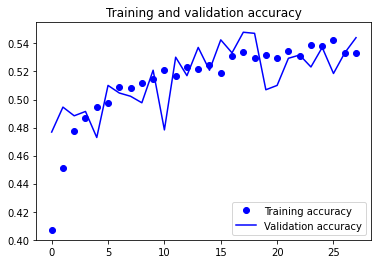

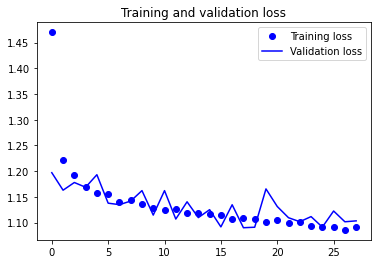

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'VGG16_updated_dataset_exp2.h5'))

45/45 [==============================] - 32s 619ms/step - loss: 1.0883 - accuracy: 0.5292
Test accuracy: 0.529
Test loss: 1.088
Classification report: 
              precision    recall  f1-score   support

           0     0.4789    0.3148    0.3799       324
           1     0.5533    0.4299    0.4839       314
           2     0.4802    0.6675    0.5586       400
           3     0.6047    0.6425    0.6230       400

    accuracy                         0.5292      1438
   macro avg     0.5293    0.5137    0.5113      1438
weighted avg     0.5305    0.5292    0.5199      1438



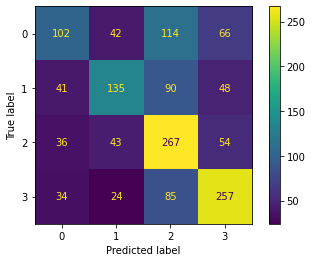

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
gc.collect()
K.clear_session()

## **Experiment 2 Fine Tune Last Block] Data Augumentation + Global AVG Pooling + Dense + Dropout**

In [ ]:
updated_dataset_aug_model = 'VGG16_updated_dataset_exp2'

In [ ]:
model = get_model_to_fine_tune(updated_dataset_aug_model, num_of_layers=3)
compile_model(model, learning_rate=1e-4) # Use a low learning rate to limit the magnitude of the modifications

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                      

In [ ]:
history = run_model(model, 'VGG16_updated_dataset_ft_exp2', train_set=train_set, val_set=val_set, epochs=20, patience=7, monitor='val_loss')

Epoch 1/20
349/349 [==============================] - ETA: 0s - loss: 1.2310 - accuracy: 0.4554
Epoch 00001: val_loss improved from inf to 1.07448, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/VGG16_updated_dataset_ft_exp2.h5
349/349 [==============================] - 278s 362ms/step - loss: 1.2310 - accuracy: 0.4554 - val_loss: 1.0745 - val_accuracy: 0.5565 - lr: 1.0000e-04
Epoch 2/20
349/349 [==============================] - ETA: 0s - loss: 1.0990 - accuracy: 0.5450
Epoch 00002: val_loss improved from 1.07448 to 1.05201, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/VGG16_updated_dataset_ft_exp2.h5
349/349 [==============================] - 111s 317ms/step - loss: 1.0990 - accuracy: 0.5450 - val_loss: 1.0520 - val_accuracy: 0.5588 - lr: 1.0000e-04
Epoch 3/20
349/349 [==============================] - ETA: 0s - loss: 1.0574 - accuracy: 0.5682
Epoch 00003: val_loss improved from 1.05201 to 1.04789, saving model to /content/drive/MyDrive/CIDL_Group/tmp_mo

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'VGG16_updated_dataset_ft_exp2.h5'))

45/45 [==============================] - 31s 613ms/step - loss: 0.9477 - accuracy: 0.6314
Test accuracy: 0.631
Test loss: 0.948
Classification report: 
              precision    recall  f1-score   support

           0     0.5570    0.5432    0.5500       324
           1     0.6846    0.6497    0.6667       314
           2     0.6293    0.6450    0.6370       400
           3     0.6522    0.6750    0.6634       400

    accuracy                         0.6314      1438
   macro avg     0.6307    0.6282    0.6293      1438
weighted avg     0.6314    0.6314    0.6312      1438



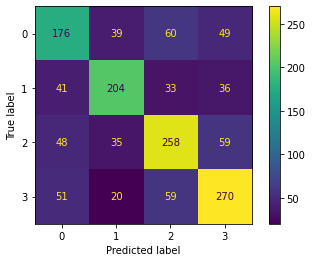

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
gc.collect()
K.clear_session()

## **Experiment 2 Fine Tune Last 3 Blocks] Data Augumentation + Global AVG Pooling + Dense + Dropout**

In [ ]:
model = get_model_to_fine_tune(updated_dataset_aug_model, num_of_layers=9)
compile_model(model, learning_rate=1e-5) # Use a low learning rate to limit the magnitude of the modifications

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                      

In [ ]:
history = run_model(model, 'VGG16_updated_dataset_ft2_exp2', train_set=train_set, val_set=val_set, epochs=50, patience=7, monitor='val_loss')

Epoch 1/50
349/349 [==============================] - ETA: 0s - loss: 1.1112 - accuracy: 0.5226
Epoch 00001: val_loss improved from inf to 1.08568, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/VGG16_updated_dataset_ft2_exp2.h5
349/349 [==============================] - 105s 297ms/step - loss: 1.1112 - accuracy: 0.5226 - val_loss: 1.0857 - val_accuracy: 0.5302 - lr: 1.0000e-05
Epoch 2/50
349/349 [==============================] - ETA: 0s - loss: 1.0563 - accuracy: 0.5597
Epoch 00002: val_loss did not improve from 1.08568
349/349 [==============================] - 103s 295ms/step - loss: 1.0563 - accuracy: 0.5597 - val_loss: 1.1128 - val_accuracy: 0.5108 - lr: 1.0000e-05
Epoch 3/50
349/349 [==============================] - ETA: 0s - loss: 1.0370 - accuracy: 0.5717
Epoch 00003: val_loss improved from 1.08568 to 1.00923, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/VGG16_updated_dataset_ft2_exp2.h5
349/349 [==============================] - 105s 301ms/step 

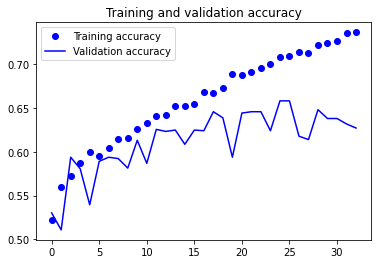

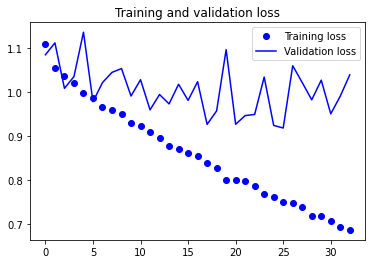

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'VGG16_updated_dataset_ft2_exp2.h5'))

45/45 [==============================] - 6s 136ms/step - loss: 0.9369 - accuracy: 0.6405
Test accuracy: 0.640
Test loss: 0.937
Classification report: 
              precision    recall  f1-score   support

           0     0.6082    0.4599    0.5237       324
           1     0.6636    0.6911    0.6771       314
           2     0.5769    0.7600    0.6559       400
           3     0.7404    0.6275    0.6793       400

    accuracy                         0.6405      1438
   macro avg     0.6473    0.6346    0.6340      1438
weighted avg     0.6483    0.6405    0.6372      1438



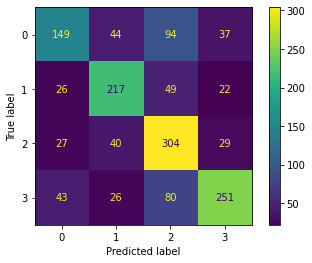

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
gc.collect()
K.clear_session()

# **Preprocessed Dataset**

In [ ]:
!unzip /content/drive/MyDrive/CIDL_Group/DATASET_PREPROCESSED.zip -d /content

Streaming output truncated to the last 5000 lines.
  inflating: /content/content/drive/MyDrive/CIDL_Group/DATASET_PREPROCESSED/train/Effusion/00029596_001.png  
  inflating: /content/content/drive/MyDrive/CIDL_Group/DATASET_PREPROCESSED/train/Effusion/00025252_014.png  
  inflating: /content/content/drive/MyDrive/CIDL_Group/DATASET_PREPROCESSED/train/Effusion/00010007_168.png  
  inflating: /content/content/drive/MyDrive/CIDL_Group/DATASET_PREPROCESSED/train/Effusion/00021565_008.png  
  inflating: /content/content/drive/MyDrive/CIDL_Group/DATASET_PREPROCESSED/train/Effusion/00018125_003.png  
  inflating: /content/content/drive/MyDrive/CIDL_Group/DATASET_PREPROCESSED/train/Effusion/00028509_011.png  
  inflating: /content/content/drive/MyDrive/CIDL_Group/DATASET_PREPROCESSED/train/Effusion/00010145_002.png  
  inflating: /content/content/drive/MyDrive/CIDL_Group/DATASET_PREPROCESSED/train/Effusion/00010805_035.png  
  inflating: /content/content/drive/MyDrive/CIDL_Group/DATASET_PREPRO

In [ ]:
UPDATED_DATASET = '/content/content/drive/MyDrive/CIDL_Group/DATASET_PREPROCESSED'
TRAIN_PATH = os.path.join(UPDATED_DATASET, 'train')
VAL_PATH = os.path.join(UPDATED_DATASET, 'val')
TEST_PATH = os.path.join(UPDATED_DATASET, 'test')

CLASSES = os.listdir(TRAIN_PATH)

100%|██████████| 4/4 [00:00<00:00, 35.96it/s]


Number of Effusion: 2279, proportion: 0.20452301893565467
Number of Infiltration: 3240, proportion: 0.2907655030063717
Number of No Finding: 3240, proportion: 0.2907655030063717
Number of Atelectasis: 2384, proportion: 0.2139459750516019


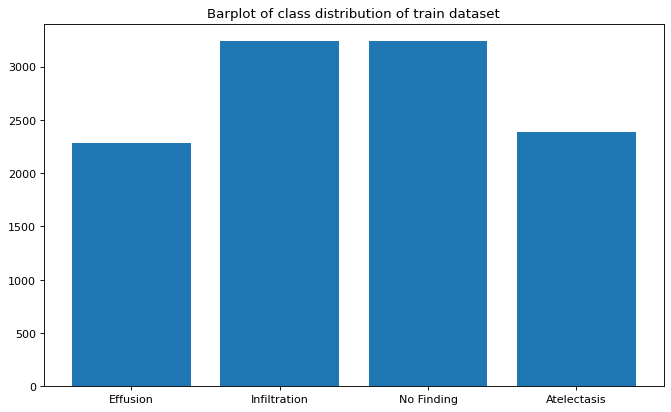

100%|██████████| 4/4 [00:00<00:00, 345.85it/s]


Number of Effusion: 283, proportion: 0.21904024767801858
Number of Infiltration: 360, proportion: 0.2786377708978328
Number of No Finding: 360, proportion: 0.2786377708978328
Number of Atelectasis: 289, proportion: 0.2236842105263158


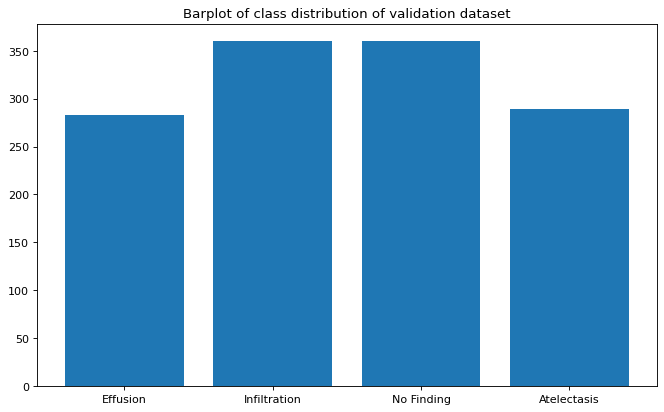

100%|██████████| 4/4 [00:00<00:00, 389.09it/s]


Number of Effusion: 314, proportion: 0.21835883171070933
Number of Infiltration: 400, proportion: 0.27816411682892905
Number of No Finding: 400, proportion: 0.27816411682892905
Number of Atelectasis: 324, proportion: 0.22531293463143254


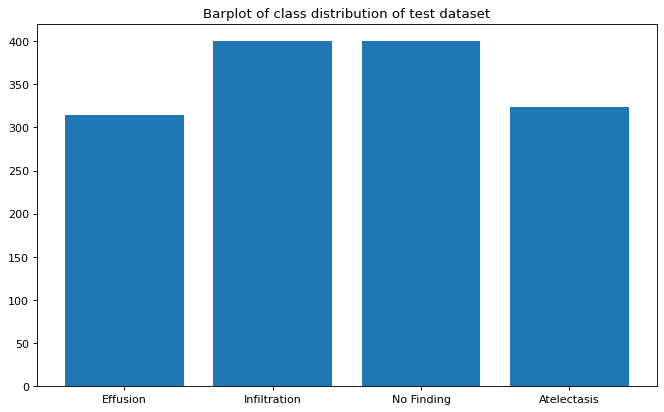

In [ ]:
plot_class_distribution(TRAIN_PATH, 'train')
plot_class_distribution(VAL_PATH, 'validation')
plot_class_distribution(TEST_PATH, 'test')

In [ ]:
train_set = load_training_set(IMAGE_SIZE, BATCH_SIZE)
val_set = load_validation_set(IMAGE_SIZE, BATCH_SIZE)
test_set = load_test_set(IMAGE_SIZE, BATCH_SIZE)

Found 11143 files belonging to 4 classes.
Found 1292 files belonging to 4 classes.
Found 1438 files belonging to 4 classes.


## **Experiment 1] Data Augumentation + Global AVG Pooling + Dense + Dropout**

In [ ]:
inputs = keras.Input(shape=IMAGE_SIZE + (3,))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(CLASSES), activation='softmax')(x)
model = keras.Model(inputs, outputs)
compile_model(model, learning_rate=0.001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                      

In [ ]:
history = run_model(model, 'VGG16_preprocessed_dataset_exp1', train_set=train_set, val_set=val_set, epochs=50, patience=9, monitor='val_loss')

Epoch 1/50
349/349 [==============================] - ETA: 0s - loss: 1.5823 - accuracy: 0.3848
Epoch 1: val_loss improved from inf to 1.22942, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/VGG16_preprocessed_dataset_exp1.h5
349/349 [==============================] - 255s 351ms/step - loss: 1.5823 - accuracy: 0.3848 - val_loss: 1.2294 - val_accuracy: 0.4427 - lr: 0.0010
Epoch 2/50
349/349 [==============================] - ETA: 0s - loss: 1.2434 - accuracy: 0.4395
Epoch 2: val_loss improved from 1.22942 to 1.20717, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/VGG16_preprocessed_dataset_exp1.h5
349/349 [==============================] - 112s 321ms/step - loss: 1.2434 - accuracy: 0.4395 - val_loss: 1.2072 - val_accuracy: 0.4512 - lr: 0.0010
Epoch 3/50
349/349 [==============================] - ETA: 0s - loss: 1.2170 - accuracy: 0.4569
Epoch 3: val_loss improved from 1.20717 to 1.18553, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/VGG16_prepr

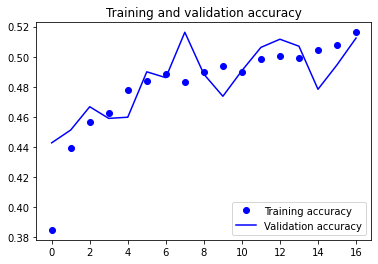

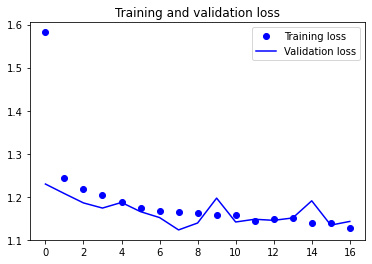

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'VGG16_preprocessed_dataset_exp1.h5'))

45/45 [==============================] - 22s 422ms/step - loss: 1.1150 - accuracy: 0.5257
Test accuracy: 0.526
Test loss: 1.115
Classification report: 
              precision    recall  f1-score   support

           0     0.4762    0.2469    0.3252       324
           1     0.5177    0.4650    0.4899       314
           2     0.4990    0.6450    0.5627       400
           3     0.5775    0.6800    0.6246       400

    accuracy                         0.5257      1438
   macro avg     0.5176    0.5092    0.5006      1438
weighted avg     0.5198    0.5257    0.5105      1438



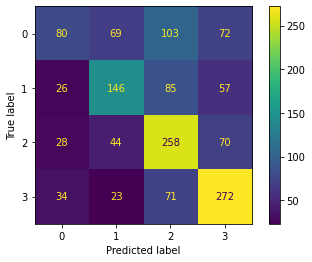

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
gc.collect()
K.clear_session()

## **Experiment 1 Fine Tune Last 3 Blocks] Data Augumentation + Global AVG Pooling + Dense + Dropout**

In [ ]:
updated_dataset_aug_model = 'VGG16_preprocessed_dataset_exp1'
model = get_model_to_fine_tune(updated_dataset_aug_model, num_of_layers=9)
compile_model(model, learning_rate=1e-5) # Use a low learning rate to limit the magnitude of the modifications

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                      

In [ ]:
history = run_model(model, 'VGG16_preprocessed_dataset_ft_exp1', train_set=train_set, val_set=val_set, epochs=50, patience=9, monitor='val_loss')

Epoch 1/50
349/349 [==============================] - ETA: 0s - loss: 1.1547 - accuracy: 0.4934
Epoch 1: val_loss improved from inf to 1.09281, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/VGG16_preprocessed_dataset_ft_exp1.h5
349/349 [==============================] - 209s 585ms/step - loss: 1.1547 - accuracy: 0.4934 - val_loss: 1.0928 - val_accuracy: 0.5480 - lr: 1.0000e-05
Epoch 2/50
349/349 [==============================] - ETA: 0s - loss: 1.1157 - accuracy: 0.5246
Epoch 2: val_loss improved from 1.09281 to 1.09203, saving model to /content/drive/MyDrive/CIDL_Group/tmp_models/VGG16_preprocessed_dataset_ft_exp1.h5
349/349 [==============================] - 202s 579ms/step - loss: 1.1157 - accuracy: 0.5246 - val_loss: 1.0920 - val_accuracy: 0.5503 - lr: 1.0000e-05
Epoch 3/50
349/349 [==============================] - ETA: 0s - loss: 1.0932 - accuracy: 0.5353
Epoch 3: val_loss did not improve from 1.09203
349/349 [==============================] - 200s 572ms/step - lo

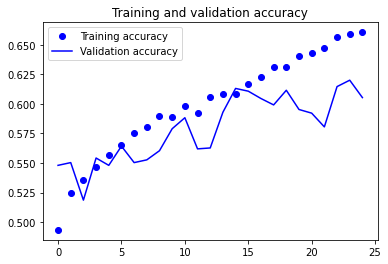

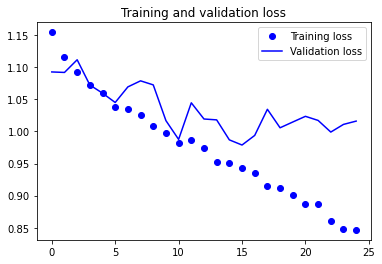

In [ ]:
show_training_and_validation_performance(history)

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_PATH, 'VGG16_preprocessed_dataset_ft_exp1.h5'))

45/45 [==============================] - 13s 279ms/step - loss: 0.9617 - accuracy: 0.6043
Test accuracy: 0.604
Test loss: 0.962
Classification report: 
              precision    recall  f1-score   support

           0     0.5115    0.4815    0.4960       324
           1     0.6500    0.6210    0.6352       314
           2     0.5654    0.7025    0.6265       400
           3     0.7054    0.5925    0.6440       400

    accuracy                         0.6043      1438
   macro avg     0.6081    0.5994    0.6004      1438
weighted avg     0.6107    0.6043    0.6039      1438



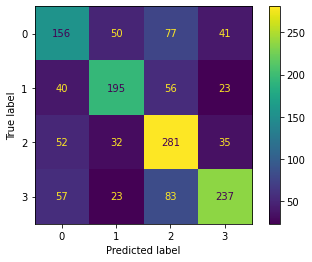

In [ ]:
evaluate_model(model_loaded, test_set)
display_confusion_matrix(model_loaded, test_set)

In [ ]:
del model
del model_loaded
gc.collect()
K.clear_session()